In [3]:
import os
import sys
import subprocess
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mplimage
import matplotlib.patches as mplpatches
import matplotlib.lines as mpllines
import matplotlib.collections as mplcollections
import matplotlib.colors as mplcolors
import matplotlib.transforms as mpltransforms
from scipy.stats import gaussian_kde, linregress

# Import COSMO style toolkit
import cosmoplot.colorbars as cosmocbars
import cosmoplot.utils as cosmoutils
import cosmoplot.style as cosmostyle

cosmostyle.set_style('article')
ccycle = cosmostyle.color_cycle

In [4]:
def cc(x, p):
    """
        Compute the Pearson correlation coefficient
        
        ---Arguments---
        x: feature data (e.g., SOAP KPCA)
        p: property data (e.g., decomposed volumes)
    """
    return np.dot(p-p.mean(), x-x.mean())/(np.std(p)*np.std(x)*len(p))

def load_framework_data(filename):
    """
        Parse data about the zeolite frameworks
        
        ---Arguments---
        filename: filename containing the zeolite structure data
            (from atomLabels.py)
    """
    
    # Initialize containers for framework properties
    framework_energies = []
    framework_volumes = []
    structure_idxs = []
    
    # Parse the framework data from the file
    with open(filename, 'r') as f:
        for line in f:
            data = line.strip().split()
            structure_idxs.append(int(data[7]))
            framework_volumes.append(float(data[8]))
            framework_energies.append(float(data[9]))

    # Convert to numpy arrays
    framework_energies = np.asarray(framework_energies)
    framework_volumes = np.asarray(framework_volumes)
    structure_idxs = np.asarray(structure_idxs)

    # Get the volumes and energies of the frameworks using
    # np.unique on the framework indices
    s, ss, sc = np.unique(structure_idxs, return_counts=True, return_index=True)
    
    # Volumes per Si
    framework_volumes = framework_volumes[ss]/sc
    
    # Mean-center the energies per Si
    framework_energies = framework_energies[ss]*sc
    framework_energies -= np.mean(framework_energies/(sc*3))*(sc*3)
    framework_energies /= sc
    
    return framework_volumes, framework_energies, structure_idxs

def build_ellipse(v, e, ax, s=1, **kwargs):
    """
        Build an error ellipse (unused)
        
        References, adapted from:
            https://matplotlib.org/3.1.0/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py
            https://carstenschelp.github.io/2018/09/14/Plot_Confidence_Ellipse_001.html
            http://www.visiondummy.com/2014/04/draw-error-ellipse-representing-covariance-matrix
        
        ---Arguments---
        v: volume data (x data)
        e: energy data (y data)
        ax: matplotlib figure axis on which to plot the ellipse
        s: scale factor for covariance
        kwargs: optional arguments for matplotlib's Ellipse
    """
    
    # Compute (scaled) covariance, means, and the parameter
    # p for determining ellipse height and width
    c = s*np.cov(v, e)
    p = c[0, 1]/(np.sqrt(c[0, 0])*np.sqrt(c[1, 1]))
    v_mean = np.mean(v)
    e_mean = np.mean(e)
    
    # Compute ellipse height and width
    w = 2*np.sqrt(1+p)
    h = 2*np.sqrt(1-p)
    E = mplpatches.Ellipse(xy=(0, 0), width=w, height=h, angle=0, **kwargs)
    
    # Scale the ellipse and transform to obtain proper rotation
    scale_w = np.sqrt(c[0, 0])
    scale_h = np.sqrt(c[1, 1])
    transf = mpltransforms.Affine2D().rotate_deg(45).scale(scale_w, scale_h).translate(v_mean, e_mean)
    E.set_transform(transf + ax.transData)
   
    return E

def build_ellipse_eig(v, e, ax):
    """
        Build an error ellipse based on eigenvalues (unused)
        
        Reference, adapted from:
            https://github.com/joferkington/oost_paper_code/blob/master/error_ellipse.py
            
        ---Arguments---
        v: volume data (x data)
        e: energy data (y data)
        ax: matplotlib figure axis on which to plot the ellipse
    """

    # Compute covariance matrix and its eigenvalues
    c = np.cov(v, e)
    eigval, eigvec = np.linalg.eigh(c)
    
    # Largest eigenvalue
    w = 2*np.sqrt(eigval[1])
    
    # Smallest eigenvalue
    h = 2*np.sqrt(eigval[0])
    
    # Rotation of ellipse based on eigenvector of larges eigenvalue
    r = np.arctan2(eigvec[1, 1], eigvec[0, 1])
    E = mplpatches.Ellipse(xy=(np.mean(v), np.mean(e)), width=w, height=h, angle=180.0/np.pi*r)
    return E

# Correlation Plots

Be sure to note that there may be outliers that don't show up in the KDE!

## 1k Data

In [5]:
# Load the data
kpca_1k_6A = np.load('../Processed_Data/DEEM_1k/PCA/6.0/kpca-0.npy')
kpca_1k_3A = np.load('../Processed_Data/DEEM_1k/PCA/3.5/kpca-0.npy')

angles_1k = np.loadtxt('../Processed_Data/DEEM_1k/Angles/angles.dat')
distances_1k = np.loadtxt('../Processed_Data/DEEM_1k/Distances/distances.dat')

angles_1k_mean = np.mean(angles_1k, axis=1)
distances_1k_mean = np.mean(distances_1k, axis=1)

In [6]:
# Compute variance of properties and KPCA representation
var3 = kpca_1k_3A.var(axis=0)
var6 = kpca_1k_6A.var(axis=0)
varA = angles_1k.var(axis=0)
varD = distances_1k.var(axis=0)

# Initialize arrays to store the correlation coefficients
ccA3 = np.zeros((len(var3), len(varA)+1))
ccA6 = np.zeros((len(var6), len(varA)+1))
ccD3 = np.zeros((len(var3), len(varD)+1))
ccD6 = np.zeros((len(var6), len(varD)+1))

# Compute correlation coefficients
for i in range(0, kpca_1k_3A.shape[1]):
    for j in range(0, angles_1k.shape[1]):
        ccA3[i, j] = cc(kpca_1k_3A[:, i], angles_1k[:, j])
    for j in range(0, distances_1k.shape[1]):
        ccD3[i, j] = cc(kpca_1k_3A[:, i], distances_1k[:, j])
        
    ccA3[i, -1] = cc(kpca_1k_3A[:, i], angles_1k_mean)
    ccD3[i, -1] = cc(kpca_1k_3A[:, i], distances_1k_mean)
    
for i in range(0, kpca_1k_6A.shape[1]): 
    for j in range(0, angles_1k.shape[1]):
        ccA6[i, j] = cc(kpca_1k_6A[:, i], angles_1k[:, j])
    for j in range(0, distances_1k.shape[1]):
        ccD6[i, j] = cc(kpca_1k_6A[:, i], distances_1k[:, j])
        
    ccA6[i, -1] = cc(kpca_1k_6A[:, i], angles_1k_mean)
    ccD6[i, -1] = cc(kpca_1k_6A[:, i], distances_1k_mean)

In [7]:
# Compute explained variance ratio
print var3[0:3]/var3.sum() # 0.50 0.13 0.06
print var6[0:3]/var6.sum() # 0.24 0.18 0.16

[0.50483811 0.13485511 0.06014612]
[0.24324087 0.18116351 0.15789074]


In [8]:
print ccA3[0:3, :]
print ccA6[0:3, :]
print ccD3[0:3, :]
print ccD6[0:3, :]

[[ 0.22872059  0.57806024  0.76762908  0.79861048  0.75269633]
 [ 0.4445265   0.5466613   0.36788264  0.16639219  0.54666379]
 [-0.24894869 -0.02362053  0.00237903  0.02263109 -0.11399584]]
[[ 0.19915126  0.23818476  0.3068278   0.32050821  0.35246443]
 [-0.20187219 -0.41073872 -0.37712454 -0.31306399 -0.43258488]
 [ 0.22757553  0.5289393   0.5174334   0.42914833  0.55903346]]
[[ 2.55370985e-01  5.96976285e-01  7.76591281e-01  7.88007434e-01
   8.22993192e-01]
 [ 4.45651129e-01  4.92627419e-01  3.00907429e-01  1.26564871e-01
   4.37693904e-01]
 [-1.93865079e-01  1.11381561e-02  2.71106593e-03  4.50222714e-04
  -5.24645536e-02]]
[[ 0.16000572  0.21705852  0.29965439  0.31665453  0.33611361]
 [-0.17013193 -0.35288798 -0.3225857  -0.27928738 -0.37623204]
 [ 0.28069998  0.54295208  0.51413101  0.41122994  0.58368291]]


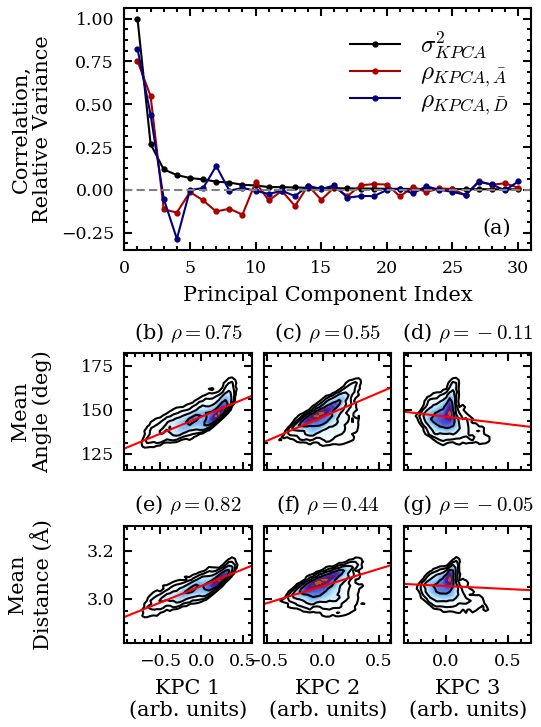

In [9]:
### DEEM 1k, SOAP 3.5 correlation plots ###

# Number of KPCA components and KDE grid divisions
nPCA = 30
n_grid = 40

# Plot labels
plot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

# KPC labels
x = np.arange(1, nPCA+1)

# Initialize figure with Gridspec
fig3 = plt.figure(figsize=(3.5, 5.5))
gs_data = mpl.gridspec.GridSpec(7, 3, height_ratios=(3, 3, 1, 1, 3, 1, 3), hspace=0.1, wspace=0.1)
axs3 = fig3.add_subplot(gs_data[0:2, :])

# Plot explained variance and energy/volume correlation
axs3.plot(x, var3[0:nPCA]/var3[0], marker='o', label=r'$\sigma^2_{KPCA}$')
axs3.plot(x, ccA3[0:nPCA, -1], marker='o', label=r'$\rho_{KPCA, \bar{A}}$')
axs3.plot(x, ccD3[0:nPCA, -1], marker='o', label=r'$\rho_{KPCA, \bar{D}}$')

# Axes labels and limits
axs3.set_xlabel('Principal Component Index')
axs3.set_ylabel('Correlation,\nRelative Variance')
axs3.axhline(y=0, linestyle='--', color='grey')
axs3.set_xlim((0, nPCA+1))

# Plot labels
axs3.text(0.95, 0.05, '%s' % plot_labels[0], 
          horizontalalignment='right', verticalalignment='bottom', transform=axs3.transAxes)

# Legend
axs3.legend(fontsize='large', labelspacing=0)

# Initialize KDE property grids
yA = np.linspace(angles_1k_mean.min() - angles_1k_mean.std(), 
                 angles_1k_mean.max() + angles_1k_mean.std(), n_grid)
yD = np.linspace(distances_1k_mean.min() - distances_1k_mean.std(), 
                 distances_1k_mean.max() + distances_1k_mean.std(), n_grid)

## Angle KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsA = fig3.add_subplot(gs_data[4, i])
    axsA_label = fig3.add_subplot(gs_data[3, i])
    
    # Remove borders from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsA_label.spines[j].set_visible(False)
    
    # Tick parameters
    axsA_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    
    # Initialize KDE data grid
    x = np.linspace(kpca_1k_3A[:, i].min()-kpca_1k_3A[:, i].std(), 
                kpca_1k_3A[:, i].max()+kpca_1k_3A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yA)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_1k_3A[:, i], angles_1k_mean]))
    zz = np.reshape(kde(pos).T, xx.shape)

    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsA.contourf(xx, yy, zz, levels=levelsf)
    axsA.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_1k_3A[:, i], angles_1k_mean)
    axsA.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsA.set_ylabel('Mean\nAngle (deg)')
    else:
        axsA.set_yticklabels([])
    
    axsA.set_xticklabels([])

    # Plot labels
    axsA_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+1], ccA3[i, -1]),
                horizontalalignment='center', verticalalignment='bottom', transform=axsA_label.transAxes)

## Distance KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsD = fig3.add_subplot(gs_data[6, i])
    axsD_label = fig3.add_subplot(gs_data[5, i])
    
    # Remove border from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsD_label.spines[j].set_visible(False)
        
    # Tick parameters
    axsD_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    
    # Initialize KDE data grid
    x = np.linspace(kpca_1k_3A[:, i].min()-kpca_1k_3A[:, i].std(), 
                kpca_1k_3A[:, i].max()+kpca_1k_3A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yD)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_1k_3A[:, i], distances_1k_mean]))
    zz = np.reshape(kde(pos).T, xx.shape)

    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsD.contourf(xx, yy, zz, levels=levelsf)
    axsD.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_1k_3A[:, i], distances_1k_mean)
    axsD.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsD.set_ylabel(u'Mean\nDistance (\u00c5)')
    else:
        axsD.set_yticklabels([])
    
    axsD.set_xlabel('KPC %d\n(arb. units)' % (i+1))
    
    # Plot labels
    axsD_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+4], ccD3[i, -1]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsD_label.transAxes)
    
fig3.align_ylabels()
#fig3.savefig('../Results/DEEM_1k/kpca_distance-angle-correlation_3.5_1k.pdf', bbox_inches='tight')
#fig3.savefig('../Results/DEEM_1k/kpca_distance-angle-correlation_3.5_1k.png', bbox_inches='tight')

plt.show()

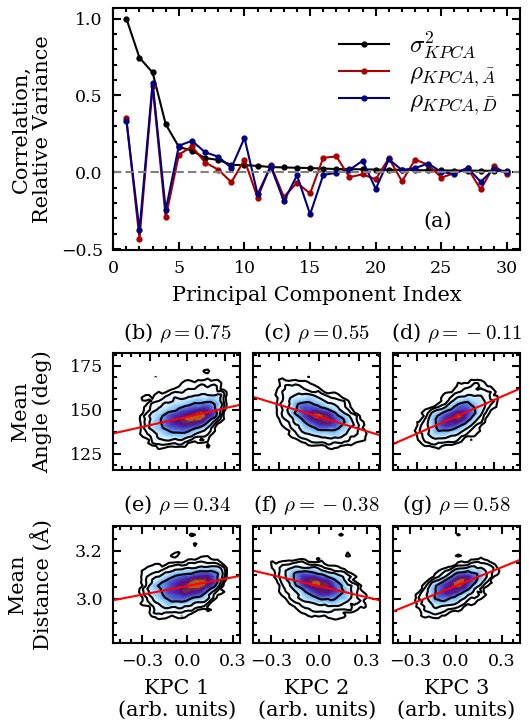

In [23]:
### DEEM 1k, SOAP 6.0 correlation plots ###

# Number of KPCA components and KDE grid divisions
nPCA = 30
n_grid = 40

# Plot labels
plot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

# KPC labels
x = np.arange(1, nPCA+1)

# Initialize figure with Gridspec
fig6 = plt.figure(figsize=(3.5, 5.5))
gs_data = mpl.gridspec.GridSpec(7, 3, height_ratios=(3, 3, 1, 1, 3, 1, 3), hspace=0.1, wspace=0.1)
axs6 = fig6.add_subplot(gs_data[0:2, :])

# Plot explained variance and energy/volume correlation
axs6.plot(x, var6[0:nPCA]/var6[0], marker='o', label=r'$\sigma^2_{KPCA}$')
axs6.plot(x, ccA6[0:nPCA, -1], marker='o', label=r'$\rho_{KPCA, \bar{A}}$')
axs6.plot(x, ccD6[0:nPCA, -1], marker='o', label=r'$\rho_{KPCA, \bar{D}}$')

# Axes labels and limits
axs6.set_xlabel('Principal Component Index')
axs6.set_ylabel('Correlation,\nRelative Variance')
axs6.axhline(y=0, linestyle='--', color='grey')
axs6.set_xlim((0, nPCA+1))

# Plot labels
axs6.text(0.95, 0.05, '%s' % plot_labels[0], 
          horizontalalignment='right', verticalalignment='bottom', transform=axs3.transAxes)

# Legend
axs6.legend(fontsize='large', labelspacing=0)

# Initialize KDE property grids
yA = np.linspace(angles_1k_mean.min() - angles_1k_mean.std(), 
                 angles_1k_mean.max() + angles_1k_mean.std(), n_grid)
yD = np.linspace(distances_1k_mean.min() - distances_1k_mean.std(), 
                 distances_1k_mean.max() + distances_1k_mean.std(), n_grid)

## Angle KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsA = fig6.add_subplot(gs_data[4, i])
    axsA_label = fig6.add_subplot(gs_data[3, i])
    
    # Remove borders from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsA_label.spines[j].set_visible(False)
    
    # Tick parameters
    axsA_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    
    # Initialize KDE data grid
    x = np.linspace(kpca_1k_6A[:, i].min()-kpca_1k_6A[:, i].std(), 
                kpca_1k_6A[:, i].max()+kpca_1k_6A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yA)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_1k_6A[:, i], angles_1k_mean]))
    zz = np.reshape(kde(pos).T, xx.shape)

    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsA.contourf(xx, yy, zz, levels=levelsf)
    axsA.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_1k_6A[:, i], angles_1k_mean)
    axsA.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsA.set_ylabel('Mean\nAngle (deg)')
    else:
        axsA.set_yticklabels([])
    
    axsA.set_xticklabels([])

    # Plot labels
    axsA_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+1], ccA3[i, -1]),
                horizontalalignment='center', verticalalignment='bottom', transform=axsA_label.transAxes)

## Distance KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsD = fig6.add_subplot(gs_data[6, i])
    axsD_label = fig6.add_subplot(gs_data[5, i])
    
    # Remove border from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsD_label.spines[j].set_visible(False)
        
    # Tick parameters
    axsD_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    
    # Initialize KDE data grid
    x = np.linspace(kpca_1k_6A[:, i].min()-kpca_1k_6A[:, i].std(), 
                kpca_1k_6A[:, i].max()+kpca_1k_6A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yD)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_1k_6A[:, i], distances_1k_mean]))
    zz = np.reshape(kde(pos).T, xx.shape)

    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsD.contourf(xx, yy, zz, levels=levelsf)
    axsD.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_1k_6A[:, i], distances_1k_mean)
    axsD.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsD.set_ylabel(u'Mean\nDistance (\u00c5)')
    else:
        axsD.set_yticklabels([])
    
    axsD.set_xlabel('KPC %d\n(arb. units)' % (i+1))
    axsD.set_xticks([-0.3, 0.0, 0.3])
    
    # Plot labels
    axsD_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+4], ccD6[i, -1]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsD_label.transAxes)
    
fig6.align_ylabels()
fig6.savefig('../Results/DEEM_1k/kpca_distance-angle-correlation_6.0_1k.pdf', bbox_inches='tight')
fig6.savefig('../Results/DEEM_1k/kpca_distance-angle-correlation_6.0_1k.png', bbox_inches='tight')

plt.show()

## 10k Data

In [24]:
angles_10k = np.loadtxt('../Processed_Data/DEEM_10k/Angles/angles.dat')
distances_10k = np.loadtxt('../Processed_Data/DEEM_10k/Distances/distances.dat')

angles_10k_mean = np.mean(angles_10k, axis=1)
distances_10k_mean = np.mean(distances_10k, axis=1)

varA = angles_10k.var(axis=0)
varD = distances_10k.var(axis=0)

In [25]:
# Compute correlation coefficient iteratively (DEEM 10k, SOAP 3.5)
#
# Online variance algorithm adapted from:
# https://en.wikipedia.org/wiki/Algorithms_for_calculating_variance
# http://jonisalonen.com/2013/deriving-welfords-method-for-computing-variance/
# https://www.johndcook.com/blog/standard_deviation/

# Initialize number of environments, batches,
# and containers for the KPCA and property data
n = 0
nBatch = 20
kpca_10k_3A = []

# Loop over batches
for i in range(0, nBatch):
    
    # Load KPCA and property data and append to their respective containers
    ikpca_10k_3A = np.load('../Processed_Data/DEEM_10k/PCA/3.5/kpca-%d.npy' % i)
    kpca_10k_3A.append(ikpca_10k_3A[:, 0:3])

    # Initialize means and variances
    if i == 0:
        var3 = np.zeros(ikpca_10k_3A.shape[1])
        mean3 = np.zeros(ikpca_10k_3A.shape[1])
        
    # Iteratively compute the mean and variance
    for j in range(0, ikpca_10k_3A.shape[0]):
        n += 1
        mean3_old = mean3.copy()
        mean3 += (ikpca_10k_3A[j, :]-mean3)/n
        var3 += (ikpca_10k_3A[j, :]-mean3)*(ikpca_10k_3A[j, :]-mean3_old)

# Concatenate the data into a single matrix
kpca_10k_3A = np.concatenate(kpca_10k_3A)

# Finalize the variances
var3 /= n

# Calculate correlation coefficients for the properties
ccA3 = np.zeros((len(var3), len(varA)+1))
ccD3 = np.zeros((len(var3), len(varD)+1))

# Re-load the batched data
m = 0
for i in range(0, nBatch):
    ikpca_10k_3A = np.load('../Processed_Data/DEEM_10k/PCA/3.5/kpca-%d.npy' % i)
    m_ikpca = ikpca_10k_3A.shape[0]
    
    # Compute correlation coefficients for the KPCA data
    for j in range(0, ikpca_10k_3A.shape[1]):
        for k in range(0, angles_10k.shape[1]):
            ccA3[j, k] += np.dot(angles_10k[m:m+m_ikpca, k]-np.mean(angles_10k, axis=0)[k], 
                                 ikpca_10k_3A[:, j]-mean3[j])/(np.sqrt(varA[k]*var3[j])*n)
        for k in range(0, distances_10k.shape[1]):
            ccD3[j, k] += np.dot(distances_10k[m:m+m_ikpca, k]-np.mean(distances_10k, axis=0)[k], 
                                 ikpca_10k_3A[:, j]-mean3[j])/(np.sqrt(varD[k]*var3[j])*n)
            
        ccA3[j, -1] += np.dot(angles_10k_mean[m:m+m_ikpca]-np.mean(angles_10k_mean), 
                                 ikpca_10k_3A[:, j]-mean3[j])/(np.sqrt(np.var(angles_10k_mean)*var3[j])*n)
        ccD3[j, -1] += np.dot(distances_10k_mean[m:m+m_ikpca]-np.mean(distances_10k_mean), 
                                 ikpca_10k_3A[:, j]-mean3[j])/(np.sqrt(np.var(distances_10k_mean)*var3[j])*n)
        
    m += m_ikpca

In [26]:
# Compute correlation coefficient iteratively (DEEM 10k, SOAP 6.0)

# Initialize number of environments, batches,
# and containers for the KPCA and property data
n = 0
nBatch = 20
kpca_10k_6A = []

# Loop over batches
for i in range(0, nBatch):
    
    # Load KPCA and property data and append to their respective containers
    ikpca_10k_6A = np.load('../Processed_Data/DEEM_10k/PCA/6.0/kpca-%d.npy' % i)
    kpca_10k_6A.append(ikpca_10k_6A[:, 0:3])

    # Initialize means and variances
    if i == 0:
        var6 = np.zeros(ikpca_10k_6A.shape[1])
        mean6 = np.zeros(ikpca_10k_6A.shape[1])
        
    # Iteratively compute the mean and variance
    for j in range(0, ikpca_10k_6A.shape[0]):
        n += 1
        mean6_old = mean3.copy()
        mean6 += (ikpca_10k_6A[j, :]-mean3)/n
        var6 += (ikpca_10k_6A[j, :]-mean3)*(ikpca_10k_6A[j, :]-mean6_old)

# Concatenate the data into a single matrix
kpca_10k_6A = np.concatenate(kpca_10k_6A)

# Finalize the variances
var6 /= n

# Calculate correlation coefficients for the properties
ccA6 = np.zeros((len(var6), len(varA)+1))
ccD6 = np.zeros((len(var6), len(varD)+1))

# Re-load the batched data
m = 0
for i in range(0, nBatch):
    ikpca_10k_6A = np.load('../Processed_Data/DEEM_10k/PCA/6.0/kpca-%d.npy' % i)
    m_ikpca = ikpca_10k_6A.shape[0]
    
    # Compute correlation coefficients for the KPCA data
    for j in range(0, ikpca_10k_6A.shape[1]):
        for k in range(0, angles_10k.shape[1]):
            ccA6[j, k] += np.dot(angles_10k[m:m+m_ikpca, k]-np.mean(angles_10k, axis=0)[k], 
                                 ikpca_10k_6A[:, j]-mean6[j])/(np.sqrt(varA[k]*var6[j])*n)
        for k in range(0, distances_10k.shape[1]):
            ccD6[j, k] += np.dot(distances_10k[m:m+m_ikpca, k]-np.mean(distances_10k, axis=0)[k], 
                                 ikpca_10k_6A[:, j]-mean6[j])/(np.sqrt(varD[k]*var6[j])*n)
            
        ccA6[j, -1] += np.dot(angles_10k_mean[m:m+m_ikpca]-np.mean(angles_10k_mean), 
                                 ikpca_10k_6A[:, j]-mean6[j])/(np.sqrt(np.var(angles_10k_mean)*var6[j])*n)
        ccD6[j, -1] += np.dot(distances_10k_mean[m:m+m_ikpca]-np.mean(distances_10k_mean), 
                                 ikpca_10k_6A[:, j]-mean6[j])/(np.sqrt(np.var(distances_10k_mean)*var6[j])*n)
        
    m += m_ikpca

In [27]:
# Compute explained variance ratio
print var3[0:3]/var3.sum()
print var6[0:3]/var6.sum()

[0.52255855 0.129359   0.06020618]
[0.24407429 0.18323301 0.15726805]


In [28]:
print ccA3[0:3, :]
print ccA6[0:3, :]
print ccD3[0:3, :]
print ccD6[0:3, :]

[[-0.23938162 -0.57805401 -0.76971879 -0.79609968 -0.75896029]
 [-0.40869457 -0.53144509 -0.37854076 -0.19748834 -0.53636955]
 [ 0.25410793  0.04094309  0.0115565  -0.0147486   0.12767412]]
[[-0.2259498  -0.26496185 -0.32605296 -0.35673138 -0.38978284]
 [ 0.15886532  0.33802015  0.33526542  0.27908046  0.36644433]
 [-0.21699797 -0.54961031 -0.54622294 -0.45098889 -0.57684534]]
[[-0.28243865 -0.61946666 -0.78957388 -0.79725899 -0.83884282]
 [-0.41815298 -0.47775619 -0.32106106 -0.16130043 -0.43824218]
 [ 0.2511267   0.02754961  0.02592192  0.00670024  0.09091379]]
[[-0.20836129 -0.2490353  -0.32294967 -0.35855898 -0.37990889]
 [ 0.14851279  0.29638196  0.2943031   0.24230713  0.32539859]
 [-0.27640696 -0.57576381 -0.54402883 -0.43944631 -0.60776008]]


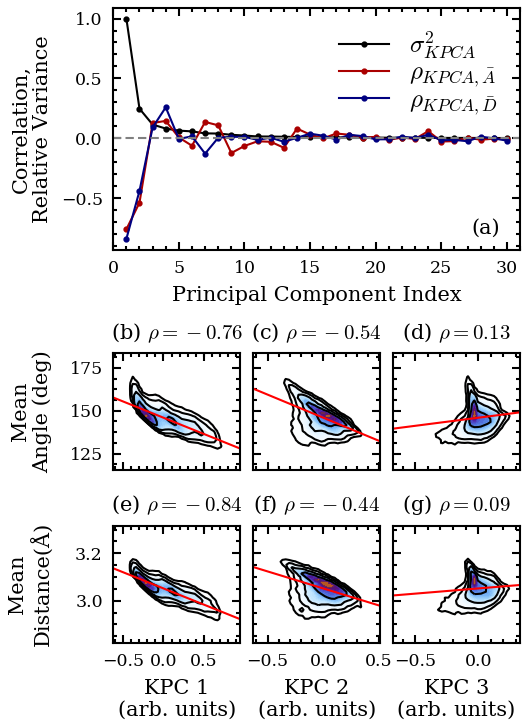

In [29]:
### DEEM 10k, SOAP 3.5 correlation plots ###

# Number of KPCA components and KDE grid divisions
nPCA = 30
n_grid = 40

# Plot labels
plot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

# KPC labels
x = np.arange(1, nPCA+1)

# Initialize figure with Gridspec
fig3 = plt.figure(figsize=(3.5, 5.5))
gs_data = mpl.gridspec.GridSpec(7, 3, height_ratios=(3, 3, 1, 1, 3, 1, 3), hspace=0.1, wspace=0.1)
axs3 = fig3.add_subplot(gs_data[0:2, :])

# Plot explained variance and energy/volume correlation
axs3.plot(x, var3[0:nPCA]/var3[0], marker='o', label=r'$\sigma^2_{KPCA}$')
axs3.plot(x, ccA3[0:nPCA, -1], marker='o', label=r'$\rho_{KPCA, \bar{A}}$')
axs3.plot(x, ccD3[0:nPCA, -1], marker='o', label=r'$\rho_{KPCA, \bar{D}}$')

# Axes labels and limits
axs3.set_xlabel('Principal Component Index')
axs3.set_ylabel('Correlation,\nRelative Variance')
axs3.axhline(y=0, linestyle='--', color='grey')
axs3.set_xlim((0, nPCA+1))

# Plot labels
axs3.text(0.95, 0.05, '%s' % plot_labels[0], 
          horizontalalignment='right', verticalalignment='bottom', transform=axs3.transAxes)

# Legend
axs3.legend(fontsize='large', labelspacing=0, loc='upper right', bbox_to_anchor=(1.0, 1.0))

# Initialize KDE property grids
yA = np.linspace(angles_10k_mean.min() - angles_10k_mean.std(), 
                 angles_10k_mean.max() + angles_10k_mean.std(), n_grid)
yD = np.linspace(distances_10k_mean.min() - distances_10k_mean.std(), 
                 distances_10k_mean.max() + distances_10k_mean.std(), n_grid)

## Angle KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsA = fig3.add_subplot(gs_data[4, i])
    axsA_label = fig3.add_subplot(gs_data[3, i])
    
    # Remove borders from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsA_label.spines[j].set_visible(False)
    
    # Tick parameters
    axsA_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    
    # Initialize KDE data grid
    x = np.linspace(kpca_10k_3A[:, i].min()-kpca_10k_3A[:, i].std(), 
                kpca_10k_3A[:, i].max()+kpca_10k_3A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yA)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_10k_3A[:, i], angles_10k_mean]))
    zz = np.reshape(kde(pos).T, xx.shape)

    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsA.contourf(xx, yy, zz, levels=levelsf)
    axsA.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_10k_3A[:, i], angles_10k_mean)
    axsA.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsA.set_ylabel('Mean\nAngle (deg)')
    else:
        axsA.set_yticklabels([])
    
    axsA.set_xticklabels([])

    # Plot labels
    axsA_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+1], ccA3[i, -1]),
                horizontalalignment='center', verticalalignment='bottom', transform=axsA_label.transAxes)

## Distance KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsD = fig3.add_subplot(gs_data[6, i])
    axsD_label = fig3.add_subplot(gs_data[5, i])
    
    # Remove border from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsD_label.spines[j].set_visible(False)
        
    # Tick parameters
    axsD_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    
    # Initialize KDE data grid
    x = np.linspace(kpca_10k_3A[:, i].min()-kpca_10k_3A[:, i].std(), 
                kpca_10k_3A[:, i].max()+kpca_10k_3A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yD)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_10k_3A[:, i], distances_10k_mean]))
    zz = np.reshape(kde(pos).T, xx.shape)

    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsD.contourf(xx, yy, zz, levels=levelsf)
    axsD.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_10k_3A[:, i], distances_10k_mean)
    axsD.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsD.set_ylabel(u'Mean\nDistance(\u00c5)')
    else:
        axsD.set_yticklabels([])
    
    axsD.set_xlabel('KPC %d\n(arb. units)' % (i+1))
    
    # Plot labels
    axsD_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+4], ccD3[i, -1]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsD_label.transAxes)
    
fig3.align_ylabels()
fig3.savefig('../Results/DEEM_10k/kpca_distance-angle-correlation_3.5_10k.pdf', bbox_inches='tight')
fig3.savefig('../Results/DEEM_10k/kpca_distance-angle-correlation_3.5_10k.png', bbox_inches='tight')

plt.show()

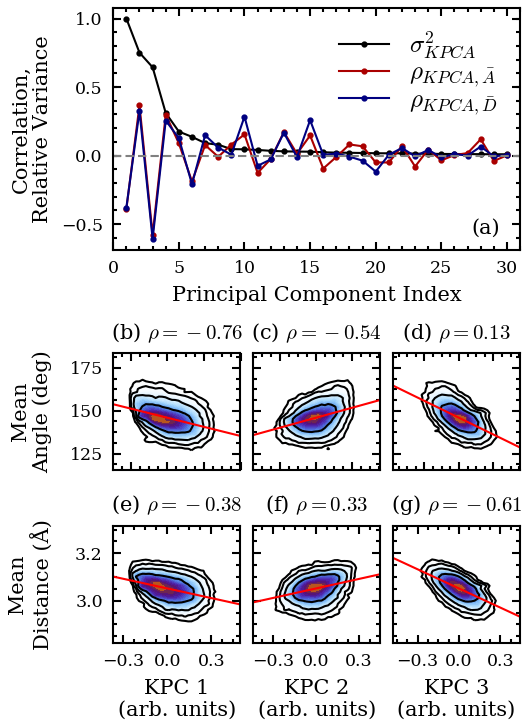

In [30]:
### DEEM 10k, SOAP 6.0 correlation plots ###

# Number of KPCA components and KDE grid divisions
nPCA = 30
n_grid = 40

# Plot labels
plot_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)']

# KPC labels
x = np.arange(1, nPCA+1)

# Initialize figure with Gridspec
fig6 = plt.figure(figsize=(3.5, 5.5))
gs_data = mpl.gridspec.GridSpec(7, 3, height_ratios=(3, 3, 1, 1, 3, 1, 3), hspace=0.1, wspace=0.1)
axs6 = fig6.add_subplot(gs_data[0:2, :])

# Plot explained variance and energy/volume correlation
axs6.plot(x, var6[0:nPCA]/var6[0], marker='o', label=r'$\sigma^2_{KPCA}$')
axs6.plot(x, ccA6[0:nPCA, -1], marker='o', label=r'$\rho_{KPCA, \bar{A}}$')
axs6.plot(x, ccD6[0:nPCA, -1], marker='o', label=r'$\rho_{KPCA, \bar{D}}$')

# Axes labels and limits
axs6.set_xlabel('Principal Component Index')
axs6.set_ylabel('Correlation,\nRelative Variance')
axs6.axhline(y=0, linestyle='--', color='grey')
axs6.set_xlim((0, nPCA+1))

# Plot labels
axs6.text(0.95, 0.05, '%s' % plot_labels[0], 
          horizontalalignment='right', verticalalignment='bottom', transform=axs6.transAxes)

# Legend
axs6.legend(fontsize='large', labelspacing=0)

# Initialize KDE property grids
yA = np.linspace(angles_10k_mean.min() - angles_10k_mean.std(), 
                 angles_10k_mean.max() + angles_10k_mean.std(), n_grid)
yD = np.linspace(distances_10k_mean.min() - distances_10k_mean.std(), 
                 distances_10k_mean.max() + distances_10k_mean.std(), n_grid)

## Angle KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsA = fig6.add_subplot(gs_data[4, i])
    axsA_label = fig6.add_subplot(gs_data[3, i])
    
    # Remove borders from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsA_label.spines[j].set_visible(False)
    
    # Tick parameters
    axsA_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    
    # Initialize KDE data grid
    x = np.linspace(kpca_10k_6A[:, i].min()-kpca_10k_6A[:, i].std(), 
                kpca_10k_6A[:, i].max()+kpca_10k_6A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yA)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_10k_6A[:, i], angles_10k_mean]))
    zz = np.reshape(kde(pos).T, xx.shape)

    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsA.contourf(xx, yy, zz, levels=levelsf)
    axsA.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_10k_6A[:, i], angles_10k_mean)
    axsA.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsA.set_ylabel('Mean\nAngle (deg)')
    else:
        axsA.set_yticklabels([])
    
    axsA.set_xticklabels([])

    # Plot labels
    axsA_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+1], ccA3[i, -1]),
                horizontalalignment='center', verticalalignment='bottom', transform=axsA_label.transAxes)

## Distance KDE ##
# Loop over the first three KPC
for i in range(0, 3):
    
    # Initialize the subplot
    axsD = fig6.add_subplot(gs_data[6, i])
    axsD_label = fig6.add_subplot(gs_data[5, i])
    
    # Remove border from dummy gridspec axes
    for j in ['top', 'bottom', 'left', 'right']:
        axsD_label.spines[j].set_visible(False)
        
    # Tick parameters
    axsD_label.tick_params(which='both', axis='both', top=False, bottom=False, left=False, right=False,
                          labeltop=False, labelbottom=False, labelleft=False, labelright=False)
    
    # Initialize KDE data grid
    x = np.linspace(kpca_10k_6A[:, i].min()-kpca_10k_6A[:, i].std(), 
                kpca_10k_6A[:, i].max()+kpca_10k_6A[:, i].std(), n_grid)
    xx, yy = np.meshgrid(x, yD)
    pos = np.vstack([xx.ravel(), yy.ravel()])

    # Compute the KDE
    kde = gaussian_kde(np.vstack([kpca_10k_6A[:, i], distances_10k_mean]))
    zz = np.reshape(kde(pos).T, xx.shape)

    # Plot KDE contours
    levelsf = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 50)
    levels = np.logspace(np.log10(zz.max()*1.0E-2), np.log10(zz.max()), 5)
    axsD.contourf(xx, yy, zz, levels=levelsf)
    axsD.contour(xx, yy, zz, levels=levels, colors='k')
    
    # Plot regression line
    m, b, r, p, s = linregress(kpca_10k_6A[:, i], distances_10k_mean)
    axsD.plot(x, m*x+b, linestyle='-', color='r')
    
    # Set tick and axes labels
    if i == 0:
        axsD.set_ylabel(u'Mean\nDistance (\u00c5)')
    else:
        axsD.set_yticklabels([])
    
    axsD.set_xlabel('KPC %d\n(arb. units)' % (i+1))
    axsD.set_xticks([-0.30, 0.0, 0.3])
    
    # Plot labels
    axsD_label.text(0.5, 0.0, r'%s $\rho = %.2f$' % (plot_labels[i+4], ccD6[i, -1]),
             horizontalalignment='center', verticalalignment='bottom', transform=axsD_label.transAxes)
    
fig6.align_ylabels()
fig6.savefig('../Results/DEEM_10k/kpca_distance-angle-correlation_6.0_10k.pdf', bbox_inches='tight')
fig6.savefig('../Results/DEEM_10k/kpca_distance-angle-correlation_6.0_10k.png', bbox_inches='tight')

plt.show()